In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import time


%matplotlib inline

In [2]:
def relu( x ):
    x = np.maximum(0,x)
    return np.minimum( 10, x )
#    return np.maximum(0,x)

In [3]:
def drelu( x ):
    return np.where( (x > 0) & (x < 10) , 1, 0 )
#    return np.where(x>0, 1, 0)

In [4]:
def trunC( x ):
    x = np.maximum(-10,x)
    return np.minimum(10, x)

In [5]:
def dtrunC(x):
    return np.where( (x > -10) & (x < 10) , 1, 0 )

In [6]:
def initialize_parameters( d_z, d_y, n_n ):
    """
    Arguments:
    n_y -- the number of features in the data
    n_n -- the number of neurons (number of samples of nu)
    
    Returns:
    parameters -- python dictionary containing parameters "C", "W", "b"
                    C -- weight matrix of shape (n_n, 1, n_y)
                    W -- weight matrix of shape (n_n, n_y, n_y)
                    b -- bias vector of shape (n_n, n_y, 1)
    """
    

    C = np.random.randn( n_n, d_y , 1) *20
    W = np.random.randn( n_n, d_y , d_z) *20
    b = np.random.randn( n_n, d_y , 1)   *20

        
    return ( C, W, b )

In [7]:
def forward_propagation( C, W, b, Z, Y, dt, lam, sigma ):
    """
    Implement forward propagation (see formulas for dX, dTheta)
    
    Arguments:
    parameters -- current value of Theta = ( C, W, b )
    Z -- data, array of size ( d_z, n_z )
    Y -- label, array of size ( d_y, n_z)
    dt, lam, sigma -- parameters of gradient update rule
    
    Returns:

    parameters -- updated value of parameter Theta
    """
    
    (d_z, n_z) = Z.shape
    d_y = Y.shape[ 0 ]
    n_n = C.shape[ 0 ]
        
    
    LZ = np.matmul( W, Z ) + b       #dimension: n_n, d_y, n_z
    AZ = relu( LZ )  
    RZ = np.mean(AZ * trunC(C) , axis=0)
    dAZ = drelu( LZ )
    BZ = trunC(C) * dAZ
    
    
    diff =  RZ  - Y       # dimension:  d_y, n_z

    
#    diff = diff + np.where(RZ>1, 0.5, 0) + np.where(RZ<-1,-0.5,0)
        
#    diff =   diff.reshape(1, d_y, n_z)
    
    # Implement dTheta formula
    dc_dF_dnu = np.mean( AZ * diff, axis = 2, keepdims = True ) * dtrunC(C)         # dimension:  n_n, d_y, 1
    
    dw_dF_dnu = np.matmul(BZ * diff, Z.T)/n_z               # dimension:  n_n, d_y, d_z
    db_dF_dnu = np.mean( BZ * diff , axis = 2, keepdims = True )        # dimension:  n_n, d_y, 1
    
    dC = - ( dc_dF_dnu + lam * C ) * dt + sigma * np.sqrt(dt) * np.random.randn( n_n, d_y, 1 ) 
    C += dC
    
    dW = - ( dw_dF_dnu + lam * W ) * dt + sigma * np.sqrt(dt) * np.random.randn( n_n, d_y, d_z )
    W += dW
    
    db = - ( db_dF_dnu + lam * b ) * dt + sigma * np.sqrt(dt) * np.random.randn( n_n, d_y, 1 )
    b += db
    
    
    cost = np.linalg.norm( diff , axis = 0)
    
    cost = np.mean(cost * cost)/2
    
    cost = np.squeeze(cost)      # To make sure cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return (cost, C, W, b)

In [8]:
def nn_model(Z, Y, n_n, minibatch_size = 32, dt = 0.1, lam = 0.01, sigma = 0.01, 
                  num_epochs = 1000, print_cost = False):
    """
    Implements a 1-layer neural network.
    
    Arguments:
    Z -- data, samples of the distribution mu_star, numpy array of shape (n_y, n_z)
    n_n -- number of neurons in each layer (number of samples of distribution nu)
    n_x -- number of samples of the distribution mu
    minibatch_size -- size of minibatch
    dt -- parameter of the gradient update rule
    lam -- parameter of the gradient update rule
    eps -- parameter of the gradient update rule
    sigma -- parameters of the gradient update rule
    num_epochs -- number of epochs of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    costs -- list of costs F calculated at each iteration of the optimization loop
    X -- samples of the learned distribution mu, array of size ( n_y, n_x ) 
    """

    tic = time.time()
    #np.random.seed(1)
    costs = []   # keep track of cost
    
    #seed = 1 
    
    ( d_z , n_z ) = Z.shape
    
    d_y = Y.shape[0]
    
    
    #seed = 1 # for constructing minibatches
    
    # Parameters initialization.
    (C, W, b) = initialize_parameters( d_z, d_y, n_n )
    
    diff_vars = []
    
    N_batch = np.floor(n_z/minibatch_size) 
    
    cost_mini = np.zeros(int(N_batch))
    
    # Loop (optimization)
    for i in range(0, num_epochs): 
        
        for j in range(0, int(N_batch)):
            
            mini_Z = Z[:, (j*minibatch_size) : ((j+1)*minibatch_size) ]
            mini_Y = Y[:, (j*minibatch_size) : ((j+1)*minibatch_size) ]
            
            # Forward propagation.
            (cum_cost, C, W, b)  = forward_propagation( C, W, b, mini_Z, mini_Y, dt, lam, sigma )
            cost_mini[j] = cum_cost
            diff_vars.append(np.var(b , axis=0))
               
        costs.append(np.mean(cost_mini))
        
        if print_cost:
            print ("Cost after epoch %i: %f" %(i, costs[i]))
            
   


    print(time.time() - tic)


    plt.plot(np.squeeze(costs))
    plt.plot(np.squeeze(diff_vars),'brown')
    return ( C, W, b, costs)

1.397939920425415


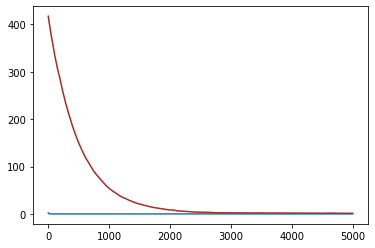

In [9]:
#regression for a simple function: training errors

#Z = np.random.exponential( 1, ( 1, 1000 ) )
Z =  np.linspace( 0 , 5.0, 12 )+np.random.randn(1,12)*0.2                 
Y =  np.cos(Z-2)
(C, W, b, costs) = nn_model( Z, Y, n_n = 100, minibatch_size = 12, dt =0.01, lam = 0.1, sigma = 0.5, num_epochs =5000)

(1, 12)


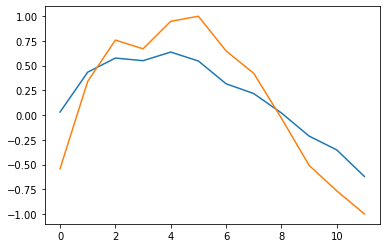

In [10]:
    #initial function and regression result
    
    LZ = np.matmul( W, Z ) + b       #dimension: n_n, d_y, n_z
    AZ = relu( LZ )
    
    F = np.mean(  AZ * trunC(C) , axis=0)
    print(F.shape)
    plt.plot(np.squeeze(F))
    plt.plot(np.squeeze(Y))

In [11]:
a = np.arange(60.).reshape(5,3,4)
b = np.arange(60.).reshape(5,4,3)
c = np.matmul(a,b)
c.shape

(5, 3, 3)

In [12]:
n=5000

a = Z.T
LZ = np.matmul( W, a[:,n] ) 
LZ = LZ+ b.reshape(50,10)       #dimension: n_n, d_y, n_z
AZ = relu( LZ )
F = np.mean(  AZ * C.reshape(50,10) , axis=0)
plt.plot(np.squeeze(F))
print(Y[n,:])

IndexError: index 5000 is out of bounds for axis 1 with size 1

In [ ]:
print(np.mod(3,2))